## Imports

In [2]:
from IPython.display import Image, display

## Simple Web Service with database

The diagram below shows a simple web service with a single database server(data tier) and web server(web tier - to handle traffic). 

* User access websites through domain names such as `api.mysite.com`
* The IP (Internet Protocol) address is returned to browser or mobile app
* Once the IP is obtained, HTTP (Hypertext Transfer Protocol) requests are sent directly to your webserver
* The web server returns HTML pages or JSON response for rendering



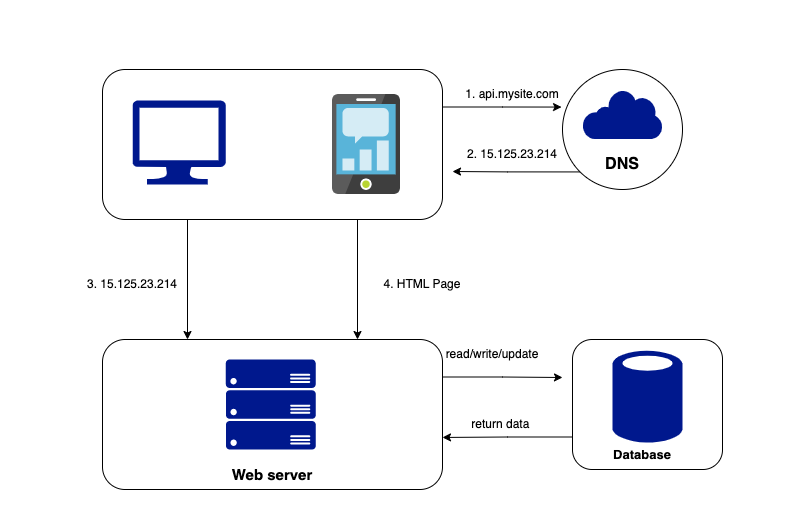

In [7]:
display(Image(filename='./diagrams/simple-web-service.png'))

**Why You should use NOSQL over SQL Databases**

* If your application requires super-low latency
* Your data are unstructured or you do not have any relational data
* You only need to serialize and deserialize (JSON, XML, YAML, etc.)
* You need to store a massive amount of data

## Vertical vs Horizontal 

**Vertical Scaling**

means `scale up` i.e. adding more compute power (CPU, RAM, etc.) to your servers. 

**Pros**

* *Simplicity* - when traffic is low vertical scaling is the way to go because it has a simple architecture
  
**Cons**

* *hard limit* - It is impossible to add unlimited CPU and memory to a single server
* *No Failover and redundancy*: If the server goes down, the app goes down completely; also if so many users are trying to access the server at the same time and it reaches its load limit, user generally experience slower response time or failure to connect to server

**Horizontal Scaling**

means `scale out`; allows you to scale by adding more servers to your resources (CPU, RAM, etc.) to your servers.  Horizontal scaling is more desirable for large applications because of the limitations of vertical scaling

## Web Service with Load balancer

Lets improve on our Web service by scaling out our servers. 

A `Load balancer` evenly distributes incoming traffic among web servers that are defined in a load-balanced set.  Below diagram shows an improved scaled out architecture of our web service

* Users now connect directly to the `public IP` of the load balancer. With this setup Clients can't access the webserver directly.
* The load balancer communicates with the web servers via private IPs. 

We have successfully solved the no failover issue and improved availability of the web tier. If `server1` goes offline, all traffic will be routed to `server2`. We will also add a new server to the server pool to balance the load.

**Note:** A private IP is an IP reachable only between servers in the same network; however unreachbale over the internet

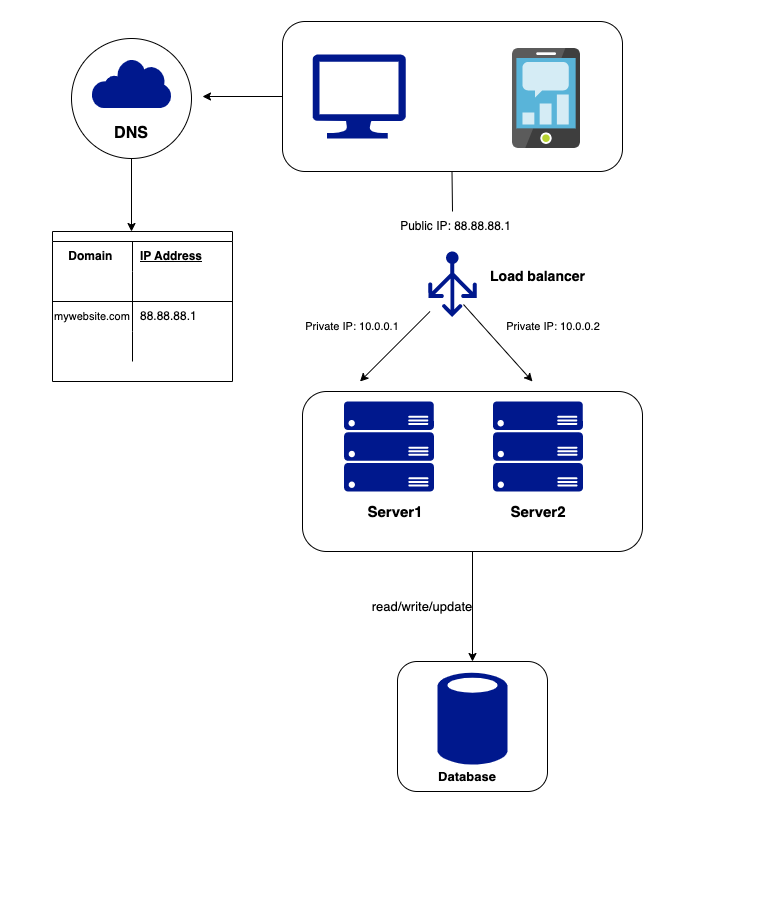

In [8]:
display(Image(filename='./diagrams/load-balancer.png'))

Next lets scale out our data tier. But first lets talk about **database replication**. 

## Database replication

Database replication is a technique for scaling out the data tier where we have: *Master database* - The original database and several copies *Slave databases*

* **Master Database**: 
  - All data modification commands like insert, delete and update must be sent to master


* **Slave Database**: 
  - Get copies of data from the master 
  - Supports read only operations
  - Several slave databases because most applications support more read than write operations


*Diagram below explains database replication* 

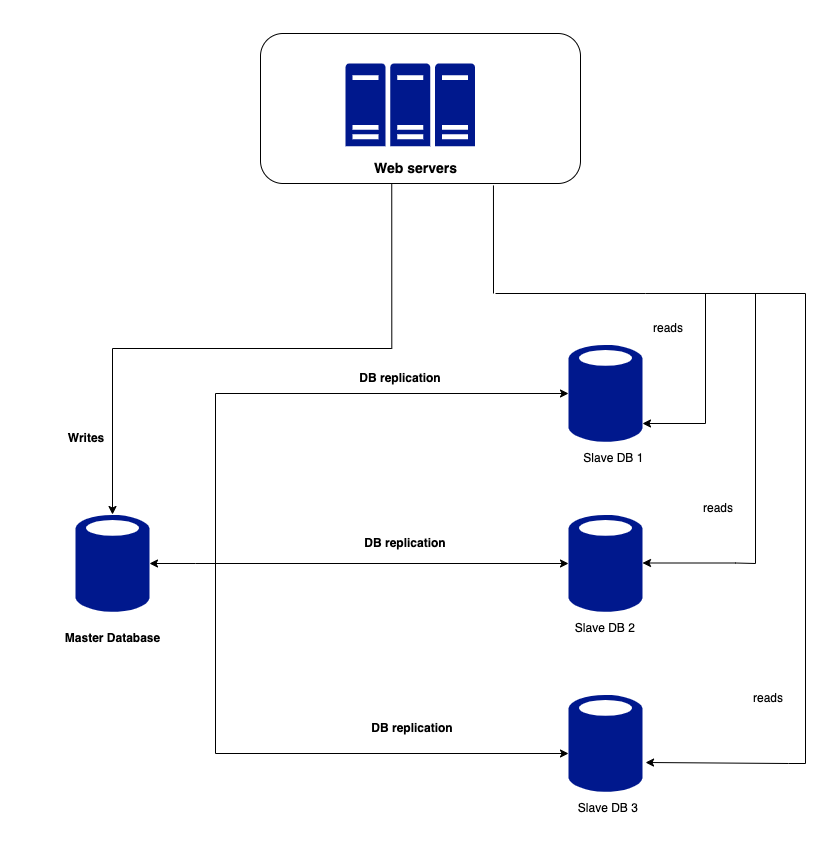

In [9]:
display(Image(filename='./diagrams/database-replication.png'))

**Advantages of database replication**

* *Better performance*: All writes operation happens on the master node and read operations are distributed across slave nodes. This model improves performance because it allows more queries to be processed parallel. 


* *Reliability* : if one DB server is destroyed by natural disaster, data is still preserved. You do not need to worry about data loss because data is replicated across different locations

* *High availability* : If a database is offline as you can access data stoted in another database server 

**Notes**

- If only one slave DB is available and it's offline; read operations are directed to master db until a new healthy server replaces the old one
- In the case several slave DBs are available, read operations are redirected to other healthy slave databases. 
- In case the master goes offline, a slave will be promoted to new master. In production systems promoting a slave to new master is complicated because slave DB might not have up to date data
  - Missing data need to be updated by running recovery script
  - Other replication methods like multi-master and circular replication can help.                         

## Web server with load balancer/ Database replication

The diagram below shows a web service with replicated database server(data tier) and scaled out web server(web tier - to handle traffic). 

* User gets the IP address of the load balancer from DNS
* User connects to the load balancer with this IP address
* HTTP requests is routed to either Server 1 or Server 2 
* A web server reads User data from a slave database
* A web server routes any data-modify operations to the master database. This includes write, update and delete operations

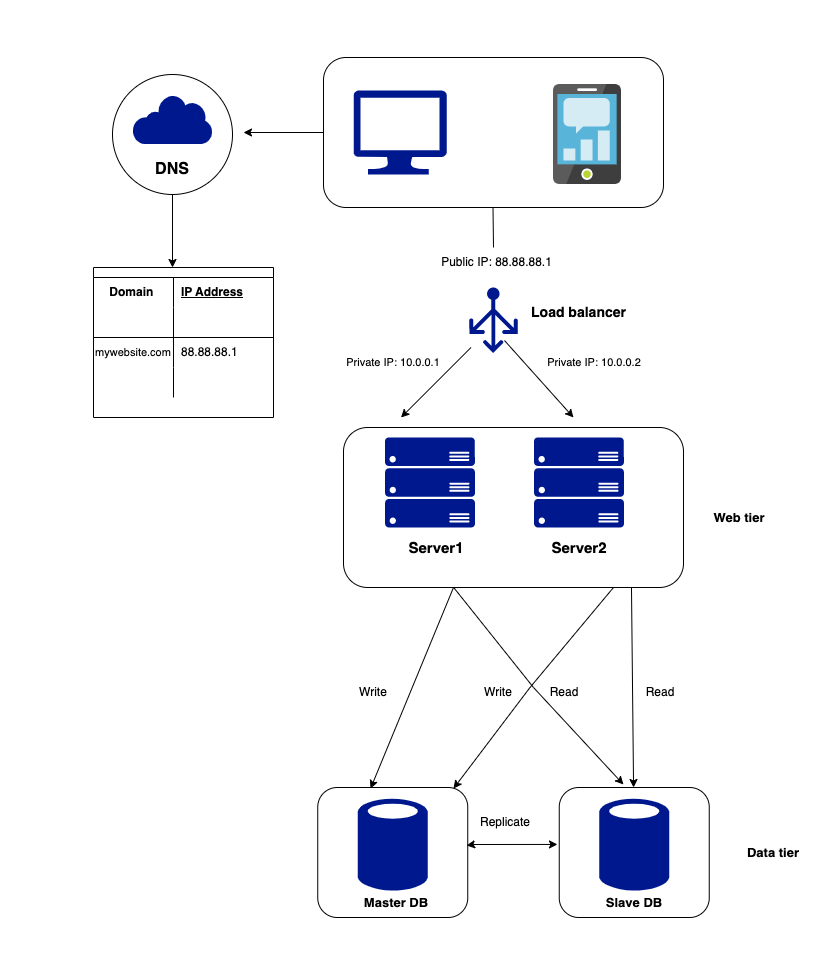

In [10]:
display(Image(filename='./diagrams/simple-web-service-replication.png'))

## Load-response time improvement 

### Caching

A `cache` is a temporarily memory that stores the result of expensive responses or frequently accessed data in memory so that subsequent requests are served more quickly. 

Database calls are expensive operations that greatly affects application performance. The cache can help mitigate this problem; the cache tier is a temporary data store layer, much faster than the database.   

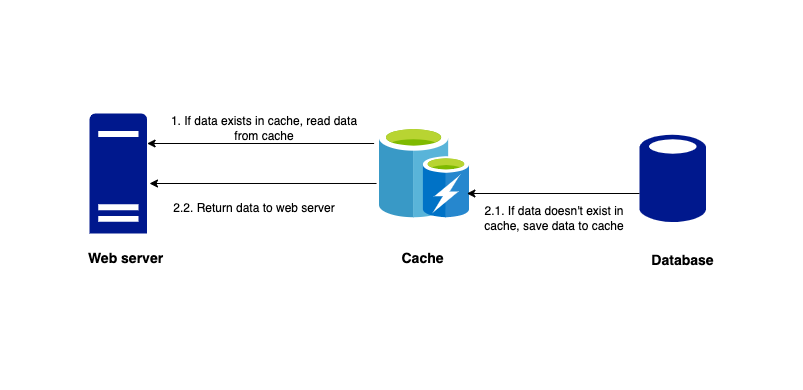

In [3]:
display(Image(filename='./diagrams/cache-tier.png'))

**Read-through-cache strategy**

* After receiving a request, web server first checks if the cache has the available response. If it does, it sends data back to the client
* If not, it queries the database, stores the response in cache and sends it back to the client

**Note**: There are other caching strategies aside from read-through-cache depending on `data type`, `size` and `access patterns`.  

**Considerations for using cache**

* **Decision to use cache** : use cache when data is read frequently but modified infrequently. Cache server are volatile so they are not ideal for persisting data. For example if cache server restarts all data in memory is lost. Thus persistent data should be stored in persistent stores

* **Expiration Policy** : It is good practise to implement an expiration policy because without it data will be stored in cache memory permanently. It is advisable not to make it too short so that the web server will not have to always reload data from database and also not too long as data become stale.

* **Consistency** : This involves keeping the data store and the cache in sync. Inconsistency can occur because data modification operations on the data store and cache are not in a single transaction. [R. Nishtala, "Facebook, Scaling Memcache at," 10th USENIX Symposium on Networked Systems Design and Implementation (NSDI ’13).](https://)

* **Mitigating Failures** : A single cache server represents a potential single point of failure `SPOF` . As a result multiple cache servers should be provisioned across different data centres.  Also it is good practise to overprovision memory by a certain percentage as the memory usage increases

* **Eviction Policy**: Once the cache memory is full, adding an additional item means an existing item has to remove. This is called eviction policy. The most popular eviction policy is `Least-Recently-Used (LRU)`, but there are other eviction policies such as `Least-Frequently-Used (LFU)`, `First-in-First-Out (FIFO)`. 


### CDN - Content Delivery Network

A **CDN** is a network of geographically dispersed servers used to deliver static content. CDN caches static contents such a images, videos, Javascript files, CSS.  Basically when a user visits a website, a CDN server closest to the user will deliver static content. The further users are from a CDN server the slower the website loads

There is also the concept of [Dynamic content caching - 9](https://), that enables certain HTML pages to be cached based on request path, query strings, cookies, and request headers. 

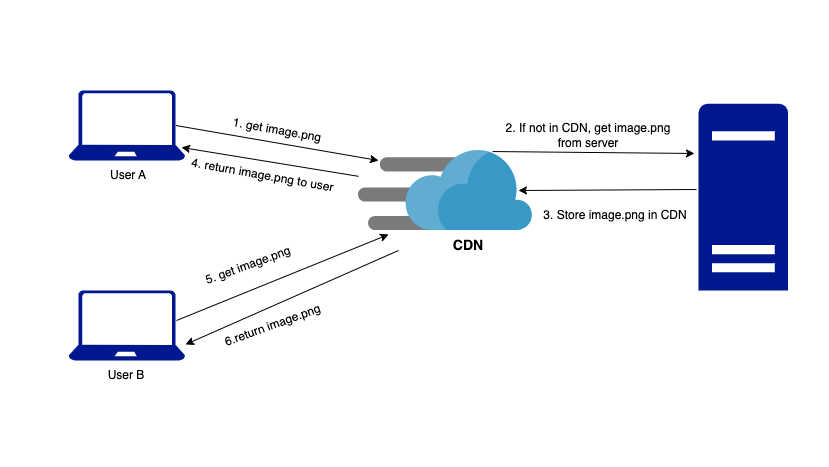

In [3]:
display(Image(filename='./diagrams/CDN.png'))

1. User A tries to get image.png by using the image URL provided by the CDN provider e.g. https://mysite.cloudfront.net/logo.jpg. 
   
2. If the CDN server does not have image.png in the cache, the CDN server requests the file from the origin e.g. `AWS S3`

3. The origin returns the image.png to the CDN server, which includes optional HTTP header `Time-to-Live (TTL)`. Which describes how long the image is cached. 

4. The CDN caches the image and return it to User A untill TTL expires

5. User B sends a request to get the same image.

6. The image is returned from cache as long as the TTL has not expired

**Considerations of using a CDN**

* *Cost*: CDNs are run by third-party providers. You are charged for data transfer in and out. It is good practise to cache infrequently used asset

* *Expiration policy*: Like caches setting an appropriate expiration time for asset is key. cache expiry time should not be too long if not asset might not be fresh and should also not be too short else it causes repeat reloading of assets from the server. 

* *CDN fallback*: You should consider how your website will cope with CDN server outages. This should be detected and request for static contents forwarded to the servers

* *Invalidating files and content versioning*

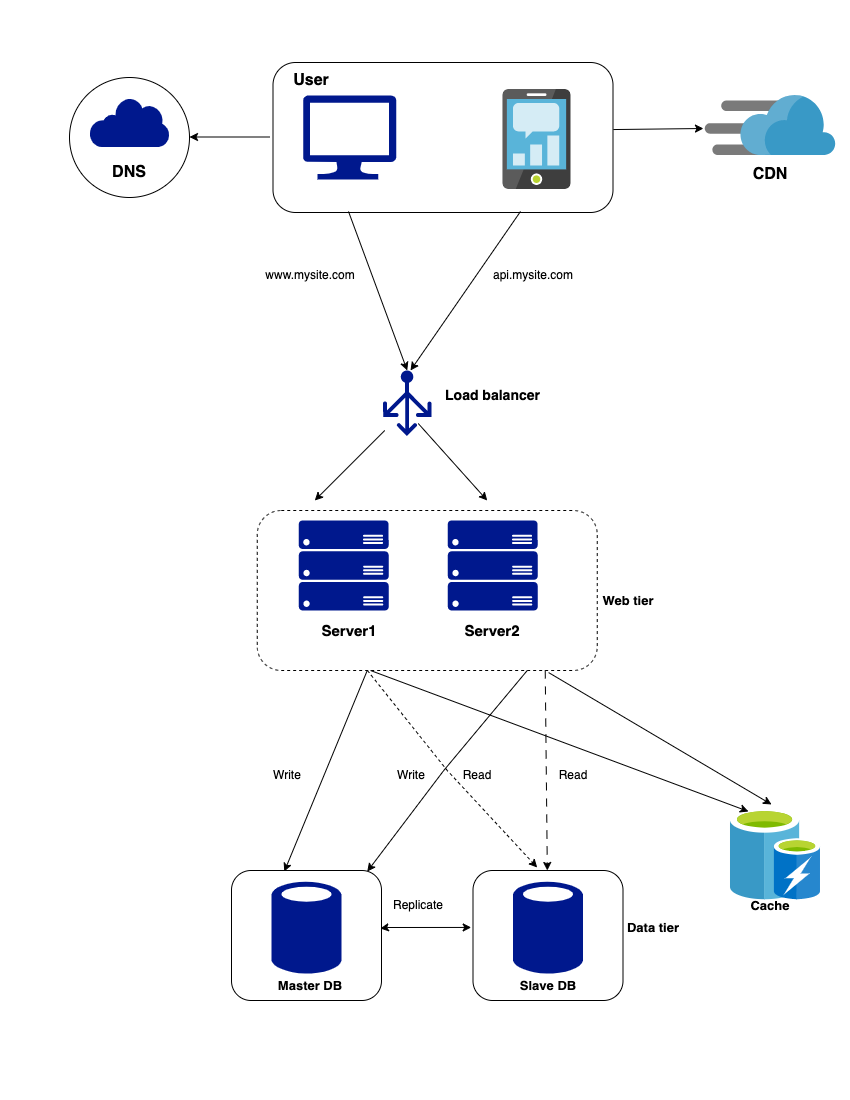

In [5]:
display(Image(filename='./diagrams/web-service-lb-cache-cdn.png'))

1. Static content/assets are served by the CDN 

2. Cache is used to optimize the data tier